In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.utils import resample

In [2]:
DATADIR = "/home/mirza/Documents/IJS/naloga1/"
data = pd.read_csv(os.path.join(DATADIR, "data60.csv"), low_memory=False)
# replace ? for NAN
data = data.replace('?', np.nan)
# Delete rows with missing values
data = data.dropna()
data = data.astype(float)
binary_cols = np.array([col for col in data.columns if "binary" in col])
binary_cols = binary_cols[np.where((data[binary_cols].nunique() <= 2) == True)[0]]
data[binary_cols] = data[binary_cols].astype("O")
data = data.sample(n = 1000, random_state = 42)
target_columns = data.iloc[:,-33:].columns
target = data.loc[:, target_columns].astype(float).sum(axis=1)
data.drop(columns=target_columns, inplace=True)
print(f"Data shape (resolution 60min) : {data.shape}\nNumber of rows {data.shape[0]}\nNumber of columns {data.shape[1]}")

Data shape (resolution 60min) : (1000, 485)
Number of rows 1000
Number of columns 485


In [10]:
df_orange = data
df_orange['target'] = target
df_orange.to_csv('orange_data_2.csv', index=False)

# Evaluacija modelov

## KNN - Regresija
Izbrani parametri modela (grid search):

 * k = 10
 * razdalja : Manhattan
 * utežen vplit najbližnjih sosedov : True

## Neuronske mreže
Parametri:

* hidden layer size : (10, 10)
* learning rate : 0.01
* L2 regularizacija : 0.001

## Odločitvena drvesa
Parametri:

* min_samples_split : 20
* min_samples_leaf : 10
* max_depth : 5

## Metoda podpornih vektorjev
Parametri:

* kernel : rbf
* C : 1
* epsilon : 0.1

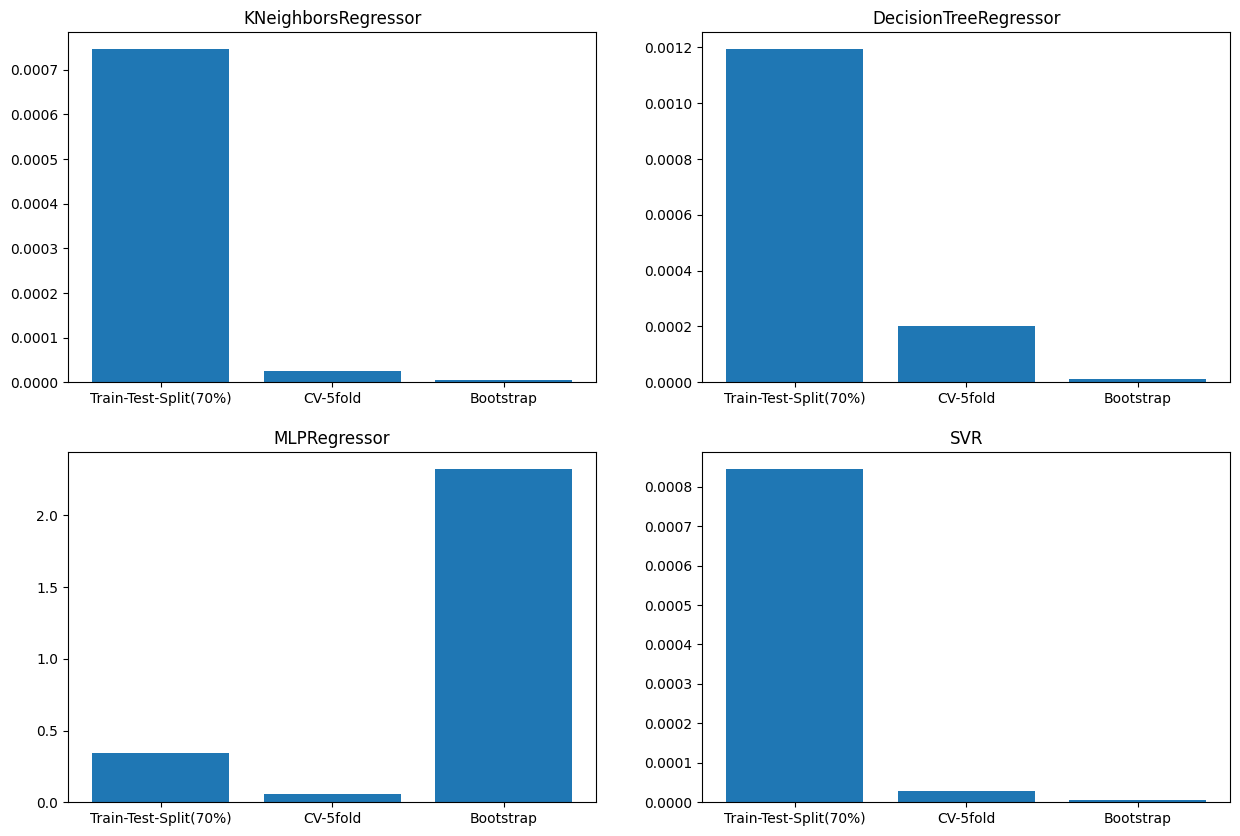

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

names = ['Train-Test-Split(70%)', 'CV-5fold', 'Bootstrap']
row, col = 0, 0
for i, name in enumerate(['KNeighborsRegressor_rmse', 'DecisionTreeRegressor_rmse', 'MLPRegressor_rmse', 'SVR_rmse']):
    
    values = [train_test_results[name]['var'], 
              cv_results[name]['var'],
              bootstrap_results[name]['var']]
    
    ax[row, col].bar(names, values)
    ax[row, col].set_title(name[:-5])

    col += 1
    if col == 2:
        row += 1
        col = 0

In [3]:
# Metrics
def rmse(predict, actual):
    predict, actual = np.array(predict), np.array(actual)
    return np.sqrt(np.mean(np.square(actual - predict)))
    # return np.sqrt(np.mean(np.square(actual - predict)) / np.sum(np.square(predict)))

# Model/pipeline definition
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category"))
    ]
)

pipe_knn = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('model', KNeighborsRegressor(n_neighbors = 9, p = 1, weights = "distance"))
    ]
)

pipe_nn = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('model', MLPRegressor(hidden_layer_sizes = (10, 10), alpha = 0.001, learning_rate_init = 0.01, max_iter=300))
    ]
)

pipe_tree = Pipeline(
    steps=[
        ('model', DecisionTreeRegressor(max_depth = 5, min_samples_split = 20, min_samples_leaf = 10))
    ]
)

pipe_svr = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('model', SVR(kernel = "rbf", C = 1, epsilon = 0.1))
    ]
)    

# Train test

In [4]:
n_iter = 30
models = [
    pipe_knn, pipe_nn, pipe_tree, pipe_svr
]
train_test_results = {type(model['model']).__name__ + '_rmse': [] for model in models}
np.random.seed(seed=42)
for i in range(n_iter):
    # smaple train test data
    X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.7)
    
    for model in models:    
        # fit models
        model.fit(X_train, y_train)
        
        # calculate predictions
        pred = model.predict(X_test)
    
        # evaluate models
        train_test_results[type(model['model']).__name__ + '_rmse'].append(rmse(pred, y_test))

In [5]:
pd.DataFrame(train_test_results)

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse
0,0.642168,1.210056,0.731439,0.573132
1,0.714786,0.816700,0.693217,0.605980
2,0.719588,0.840885,0.735283,0.566931
3,0.672417,2.392765,0.793345,0.603418
4,0.708518,0.755831,0.708333,0.592241
5,0.744396,0.830424,0.717369,0.584740
6,0.668288,0.936842,0.768822,0.591842
7,0.698595,0.854076,0.770534,0.638329
8,0.691477,0.868370,0.727968,0.585928
9,0.678846,0.782551,0.715187,0.565260


In [31]:
train_test_results = pd.DataFrame(train_test_results)[['KNeighborsRegressor_rmse', 
                                                       'MLPRegressor_rmse', 
                                                       'DecisionTreeRegressor_rmse',
                                                       'SVR_rmse']].agg(['mean', 'var'])
train_test_results

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse
mean,0.687359,1.119996,0.731615,0.599472
var,0.000746,0.345651,0.001194,0.000845


# CV

In [7]:
n_repeats = 30
n_folds = 5
cv_results = {type(model['model']).__name__ + '_rmse': [] for model in models}
cv_results['repeat'] = [j for sub in [[x + 1] * n_folds for x in range(n_repeats)] for j in sub]
cv_results['fold'] = [x + 1 for x in range(n_folds)] * n_repeats

np.random.seed(seed=42)
kf = RepeatedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=42)
for i, (train_index, test_index) in enumerate(kf.split(data)):
    # get train test folds
    X_train, y_train = data.iloc[train_index,:], target.iloc[train_index]
    X_test, y_test = data.iloc[test_index,:], target.iloc[test_index]
    
    for model in models:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        cv_results[type(model['model']).__name__ + '_rmse'].append(rmse(pred, y_test))

In [8]:
pd.DataFrame(cv_results)

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse,repeat,fold
0,0.586283,0.653836,0.732551,0.554173,1,1
1,0.700167,0.778589,0.715667,0.575779,1,2
2,0.651626,1.352531,0.741083,0.623622,1,3
3,0.706355,0.813727,0.709049,0.574955,1,4
4,0.717620,0.827446,0.777126,0.646431,1,5
...,...,...,...,...,...,...
145,0.723532,1.374752,0.766891,0.596829,30,1
146,0.665839,0.741334,0.667529,0.564776,30,2
147,0.719806,0.824711,0.760178,0.646674,30,3
148,0.643024,0.862039,0.745231,0.590699,30,4


In [9]:
pd.DataFrame(cv_results)[['repeat', 
                          'KNeighborsRegressor_rmse', 
                          'MLPRegressor_rmse', 
                          'DecisionTreeRegressor_rmse',
                          'SVR_rmse']].groupby('repeat').agg(['mean'])

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse
,mean,mean,mean,mean
repeat,,,,
1,0.672410,0.885226,0.735095,0.594992
2,0.681624,0.903704,0.735424,0.592699
3,0.686698,0.990092,0.708226,0.590855
4,0.674208,1.381798,0.731655,0.594201
5,0.682586,1.037322,0.745643,0.591421
6,0.680618,0.891016,0.726601,0.594351
7,0.677207,1.035358,0.716447,0.595061
8,0.684097,1.074036,0.722446,0.599770


In [32]:
cv_results = pd.DataFrame(cv_results)[['repeat',
                                       'KNeighborsRegressor_rmse', 
                                       'MLPRegressor_rmse', 
                                       'DecisionTreeRegressor_rmse',
                                       'SVR_rmse']].groupby('repeat').agg('mean').agg(['mean', 'var'])
cv_results

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse
mean,0.683141,1.148709,0.730087,0.596634
var,0.000025,0.056603,0.000202,0.000029


# Boostrap

In [ ]:
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from functools import partial
import joblib

def parallel_bootstrap(repeat, models, data, target, n_bootstrap_sample, results):
    
    def bootstrap_iteration(i):
        X_train = resample(data, replace=True)
        y_train = target.loc[X_train.index]
        test_idx = [x for x in data.index if x not in X_train.index]
        X_test = data.loc[test_idx, :]
        y_test = target.loc[test_idx]

        for model in models:
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            results[type(model['model']).__name__ + '_rmse'].append(rmse(pred, y_test))
    
    for _ in range(n_bootstrap_sample):
        results['repeat'].append(repeat)
        results['bootstrap_sample'].append(_ + 1)
        bootstrap_iteration(_)

    return results

repeats = [x + 1 for x in range(30)]
n_bootstrap_sample = 100
models = [pipe_knn, pipe_nn, pipe_tree, pipe_svr]

results = {type(model['model']).__name__ + '_rmse': [] for model in models}
results['repeat'] = []
results['bootstrap_sample'] = []

partial_parallel_bootstrap = partial(parallel_bootstrap,
                                     models=models,
                                     data=data,
                                     target=target, 
                                     n_bootstrap_sample=n_bootstrap_sample, 
                                     results=results)
results = joblib.Parallel(n_jobs=-1)(joblib.delayed(partial_parallel_bootstrap)(repeat) for repeat in repeats)

In [20]:
bootstrap_results = results[0].copy()
for i in range(29):
    for key, values in results[i+1].items():
        for val in values:
            bootstrap_results[key].append(val)
pd.DataFrame(bootstrap_results)

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse,repeat,bootstrap_sample
0,0.682030,1.305487,0.764372,0.580578,1,1
1,0.695585,0.908145,0.734753,0.617456,1,2
2,0.726066,0.934775,0.799633,0.625467,1,3
3,0.718963,1.322939,0.793895,0.591965,1,4
4,0.729058,0.832279,0.748332,0.605737,1,5
...,...,...,...,...,...,...
2995,0.702826,0.860538,0.756639,0.581844,30,96
2996,0.692620,1.236756,0.766798,0.613317,30,97
2997,0.757128,0.916802,0.834438,0.636406,30,98
2998,0.714355,0.947200,0.778631,0.598639,30,99


In [22]:
pd.DataFrame(bootstrap_results)[['repeat', 
                          'KNeighborsRegressor_rmse', 
                          'MLPRegressor_rmse', 
                          'DecisionTreeRegressor_rmse',
                          'SVR_rmse']].groupby('repeat').agg(['mean'])

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse
,mean,mean,mean,mean
repeat,,,,
1,0.717098,1.290110,0.757744,0.613534
2,0.715589,1.208249,0.755644,0.611970
3,0.716722,1.136092,0.755503,0.612623
4,0.711129,1.480882,0.761893,0.609849
5,0.711869,8.660413,0.749840,0.604938
6,0.719746,1.254163,0.762309,0.613277
7,0.719187,1.345732,0.757324,0.612562
8,0.713353,1.199152,0.748769,0.607428


In [33]:
bootstrap_results = pd.DataFrame(bootstrap_results)[['repeat',
                                                     'KNeighborsRegressor_rmse', 
                                                     'MLPRegressor_rmse', 
                                                     'DecisionTreeRegressor_rmse',
                                                     'SVR_rmse']].groupby('repeat').agg('mean').agg(['mean', 'var'])
bootstrap_results

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse
mean,0.716066,1.911832,0.756299,0.611557
var,0.000005,2.324151,0.000013,0.000005


# LOOCV